In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor
from pymc.model.transform.optimization import freeze_dims_and_data

from pymc_marketing.mmm import GeometricAdstock, MichaelisMentenSaturation
from pymc_marketing.mmm.multidimensional import MMM

In [2]:
warnings.filterwarnings("ignore", category=FutureWarning)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [13, 15]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 8

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [3]:
MMM

pymc_marketing.mmm.multidimensional.MMM

In [4]:
GeometricAdstock

pymc_marketing.mmm.components.adstock.GeometricAdstock

In [5]:
# Generate a date range
date_range = pd.date_range(start="2023-01-01", end="2023-01-30")

# Define countries and channels
countries = ["Venezuela", "Colombia", "Chile", "Argentina"]
channels = ["a", "b"]

# Create a DataFrame
data = []
for country in countries:
    for date in date_range:
        record = [date, country, *list(np.random.randint(100, 500, size=len(channels)))]
        data.append(record)

df = pd.DataFrame(data, columns=["date", "country", *channels])
df["target"] = df[channels].sum(axis=1) + np.random.randint(100, 500, size=len(df))
df.head()

,date,country,a,b,target
0,2023-01-01,Venezuela,107,182,392
1,2023-01-02,Venezuela,153,245,724
2,2023-01-03,Venezuela,442,112,864
3,2023-01-04,Venezuela,361,207,756
4,2023-01-05,Venezuela,120,193,576


In [6]:
# split df in train and test
df_train = df.query("date < '2023-01-15'")
df_test = df.query("date >= '2023-01-15'")

In [7]:
from pymc_marketing.prior import Prior

# Strange error here.
hierarchical_alpha = Prior(
    "Gamma",
    mu=Prior("HalfNormal", sigma=1, dims="country"),
    sigma=Prior("HalfNormal", sigma=1, dims="country"),
    dims=("channel", "country"),
)
common_lam = Prior("HalfNormal", sigma=1, dims=("channel",))
priors = {
    "alpha": hierarchical_alpha,
    "lam": common_lam,
}

# Not working with hierarchical priors

In [8]:
# Strange error here.
hierarchical_alpha = Prior(
    "Gamma",
    mu=Prior("HalfNormal", sigma=1, dims="country"),
    sigma=Prior("HalfNormal", sigma=1, dims="country"),
    dims=("channel", "country"),
)
common_lam = Prior("HalfNormal", sigma=1, dims=("channel",))
priors = {
    "alpha": hierarchical_alpha,
    "lam": common_lam,
}

saturation = MichaelisMentenSaturation(priors=priors)

In [9]:
saturation.model_config

{'saturation_alpha': Prior("Gamma", mu=Prior("HalfNormal", sigma=1, dims="country"), sigma=Prior("HalfNormal", sigma=1, dims="country"), dims=("channel", "country")),
 'saturation_lam': Prior("HalfNormal", sigma=1, dims="channel")}

In [10]:
alpha = Prior("HalfNormal", sigma=1, dims="channel")
adstock = GeometricAdstock(l_max=2)
adstock.model_config

{'adstock_alpha': Prior("Beta", alpha=1, beta=3)}

In [11]:
mmm = MMM(
    date_column="date",
    target_column="target",
    channel_columns=["a", "b"],
    dims=("country",),
    adstock=adstock,
    saturation=saturation,
    yearly_seasonality=12,
    time_varying_media=True,
    time_varying_intercept=True,
)

In [12]:
mmm.build_model(
    X=df_train.drop(columns="target"),
    y=df_train.set_index(["date", "country"])["target"],
)

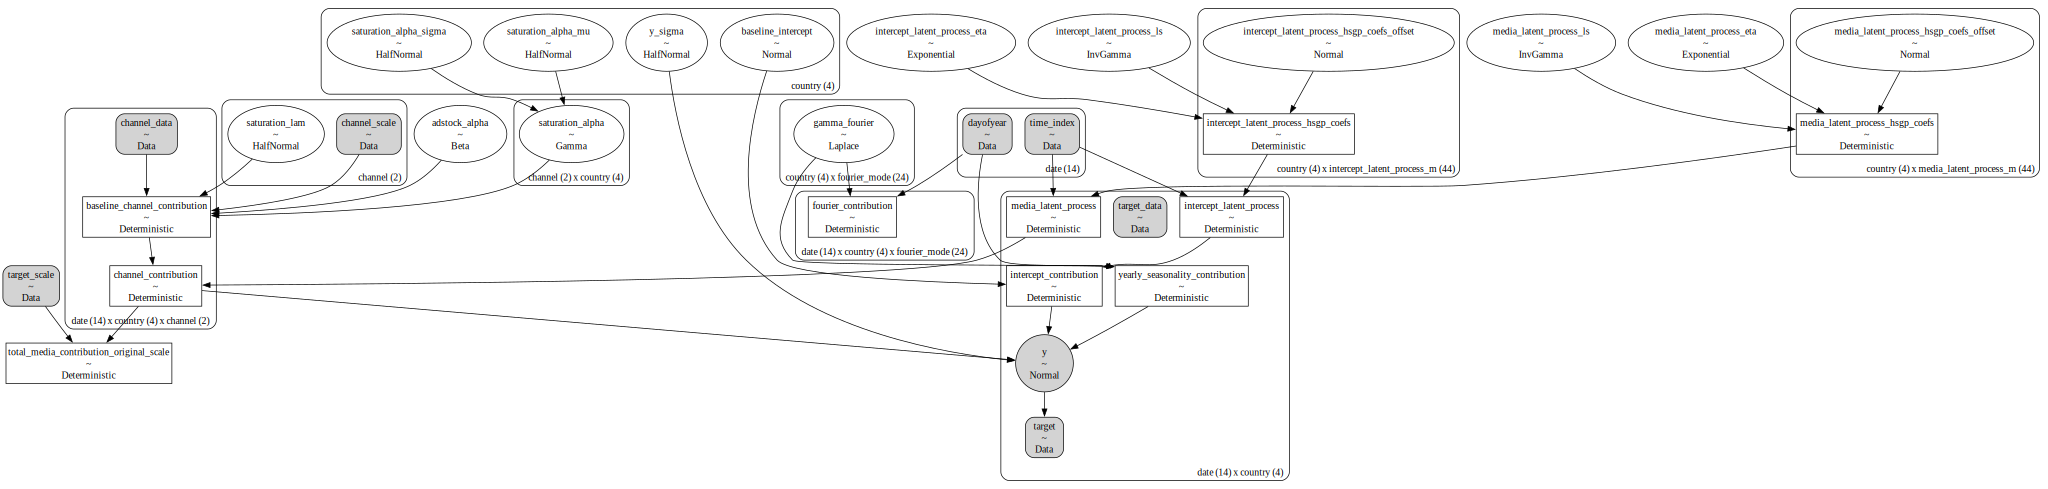

In [13]:
pm.model_to_graphviz(mmm.model)

In [14]:
mmm.add_original_scale_contribution_variable(
    var=["intercept_contribution", "channel_contribution"]
)

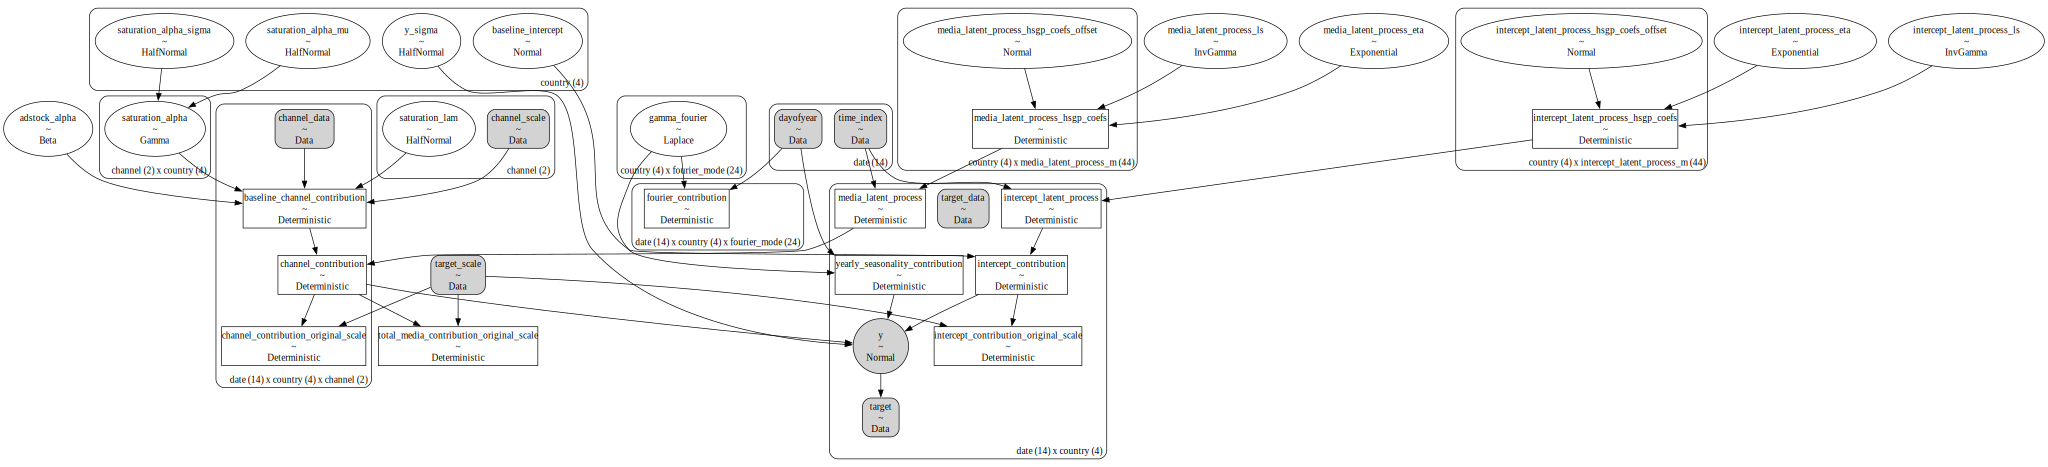

In [15]:
pm.model_to_graphviz(mmm.model)

In [16]:
pytensor.dprint(
    freeze_dims_and_data(mmm.model)["channel_contribution_original_scale"],
    depth=4,
    print_type=True,
)

Mul [id A] <Tensor3(float64, shape=(14, 4, 2))> 'channel_contribution_original_scale'
 ├─ Mul [id B] <Tensor3(float64, shape=(14, 4, 2))> 'channel_contribution'
 │  ├─ True_div [id C] <Tensor3(float64, shape=(14, 4, 2))> 'baseline_channel_contribution'
 │  │  ├─ Mul [id D] <Tensor3(float64, shape=(14, 4, 2))>
 │  │  └─ Add [id E] <Tensor3(float64, shape=(14, 4, 2))>
 │  └─ ExpandDims{axis=2} [id F] <Tensor3(float64, shape=(14, 4, 1))>
 │     └─ Blockwise{dot, (m,k),(k,n)->(m,n)} [id G] <Matrix(float64, shape=(14, 4))> 'media_latent_process'
 └─ ExpandDims{axes=[0, 1, 2]} [id H] <Tensor3(float64, shape=(1, 1, 1))>
    └─ target_scale{1369.0} [id I] <Scalar(float64, shape=())>


In [17]:
mmm.fit(
    X=df_train.drop(columns="target"),
    y=df_train.set_index(["date", "country"])["target"],
    chains=4,
    target_accept=0.85,
    nuts_sampler="numpyro",
    random_seed=42,
)

mmm.sample_posterior_predictive(
    X=df_train.drop(columns="target"),
    extend_idata=True,
    combined=True,
    random_seed=42,
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2025-02-02 13:35:52.955991: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %reduce.11 = f64[4,1000,14,4,2]{4,3,2,1,0} reduce(f64[4,1000,1,14,4,2]{5,4,3,2,1,0} %broadcast.16, f64[] %constant.31), dimensions={2}, to_apply=%region_7.208, metadata={op_name="jit(process_fn)/jit(main)/reduce_prod" source_file="/var/folders/f0/rbz8xs8s17n3k3f_ccp31bvh0000gn/T/tmptv5bhv66" source_line=145}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2025-02-02 13:35:53.817371: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.866398s
Constant folding an instruction is taking 

Output()

<xarray.Dataset> Size: 2MB
Dimensions:  (date: 14, country: 4, sample: 4000)
Coordinates:
  * date     (date) datetime64[ns] 112B 2023-01-01 2023-01-02 ... 2023-01-14
  * country  (country) <U9 144B 'Argentina' 'Chile' 'Colombia' 'Venezuela'
  * sample   (sample) object 32kB MultiIndex
  * chain    (sample) int64 32kB 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 32kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    y        (date, country, sample) float64 2MB 0.5093 0.4783 ... 0.6767 0.8079
Attributes:
    created_at:                 2025-02-02T11:35:55.152361+00:00
    arviz_version:              0.20.0
    inference_library:          pymc
    inference_library_version:  5.20.0

In [18]:
mmm.idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data
	> fit_data
	> posterior_predictive

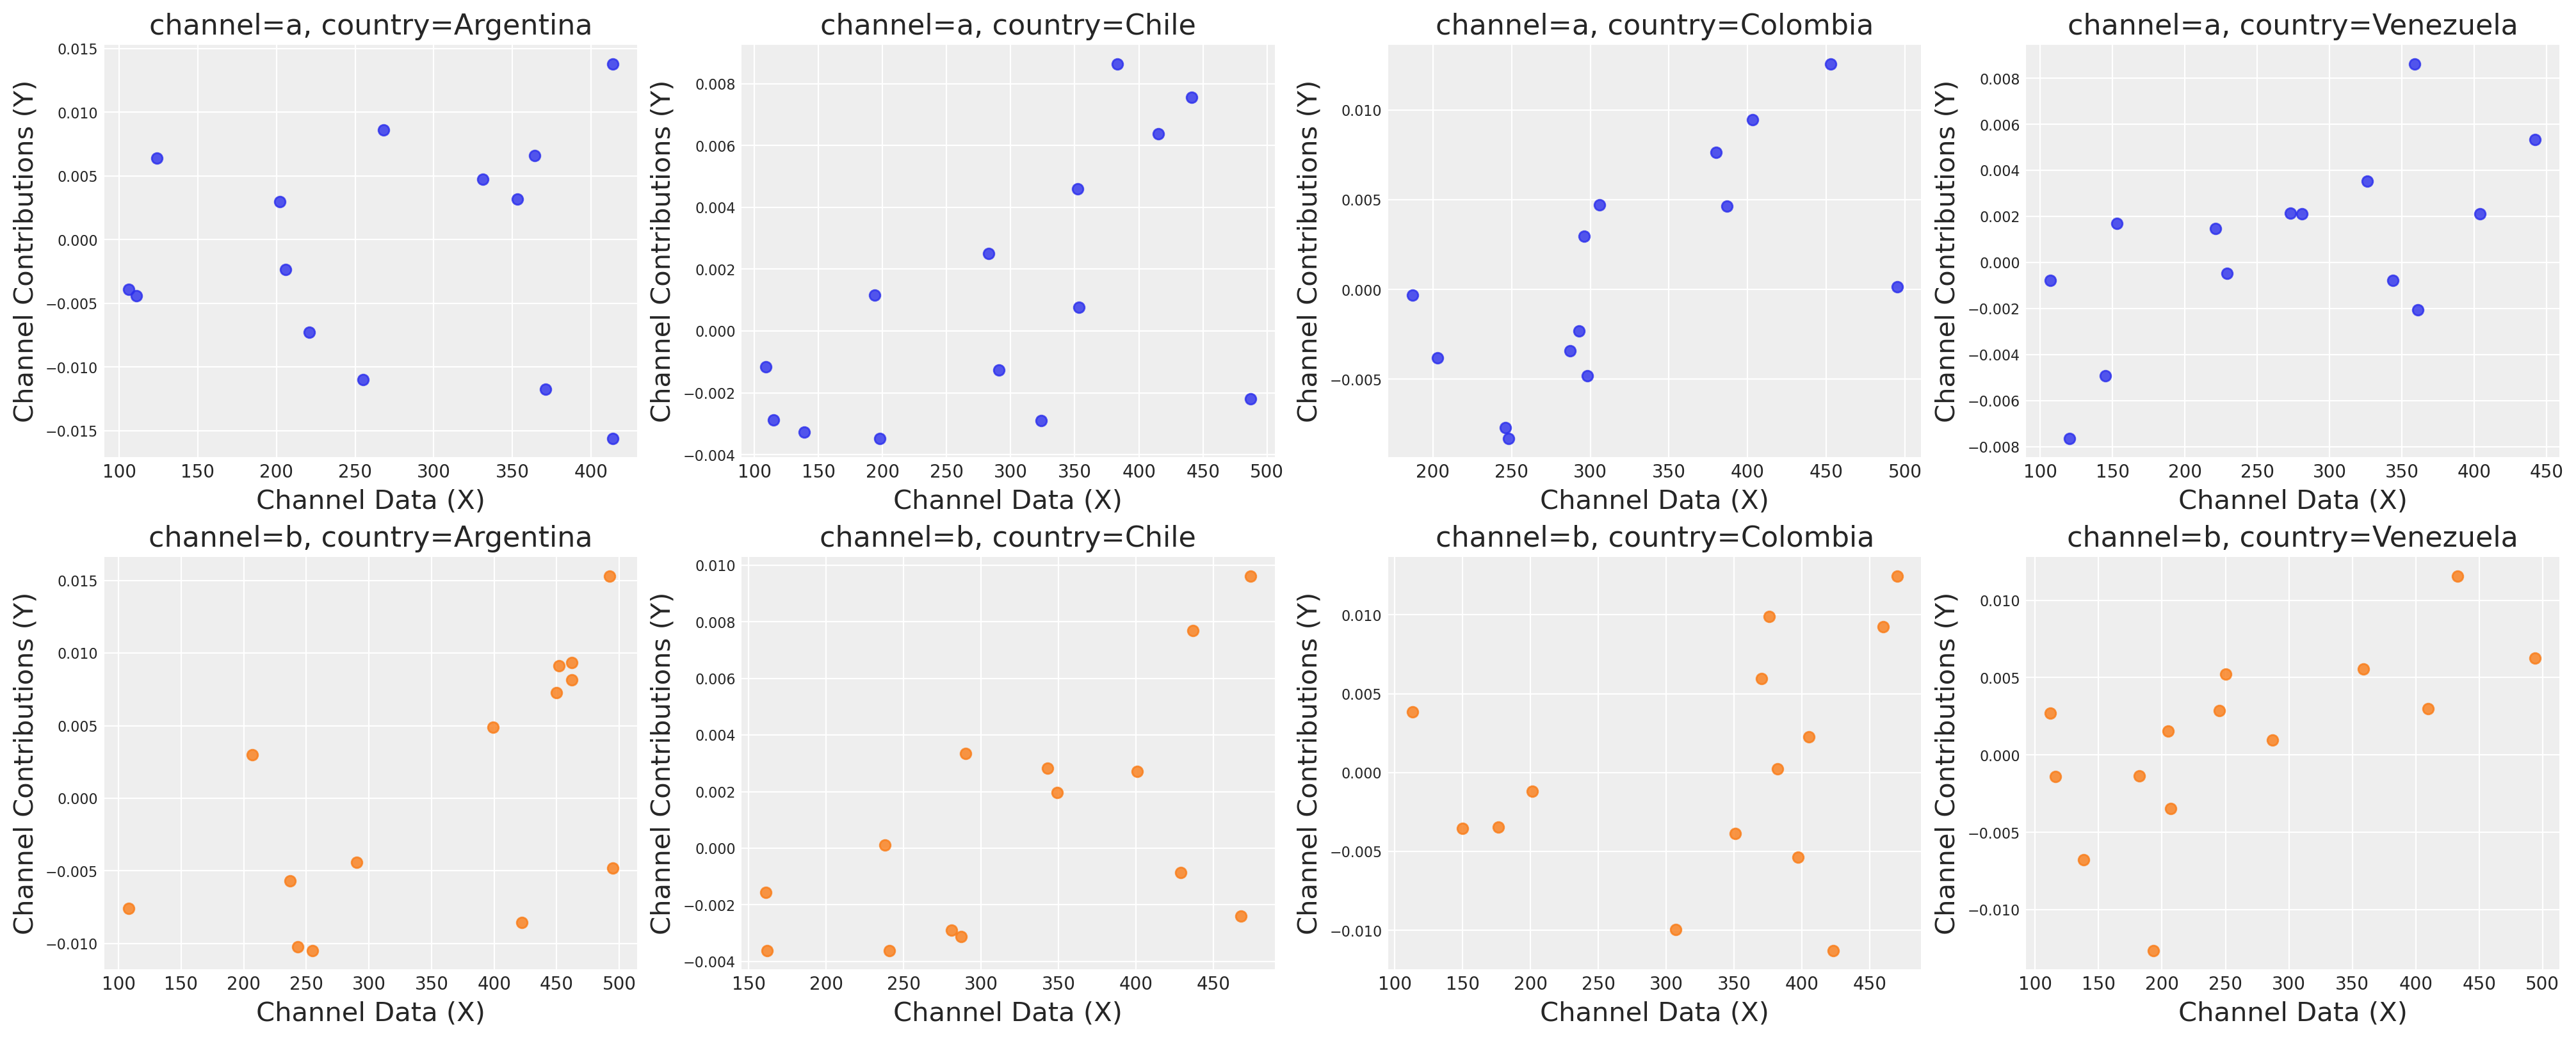

In [19]:
mmm.plot.saturation_curves_scatter();

In [20]:
_y_in_sample = mmm.sample_posterior_predictive(
    X=df_train.drop(columns="target"),
    extend_idata=False,
    include_last_observations=False,
    random_seed=42,
    var_names=["channel_contribution", "intercept_contribution"],
)

Sampling: []


Output()

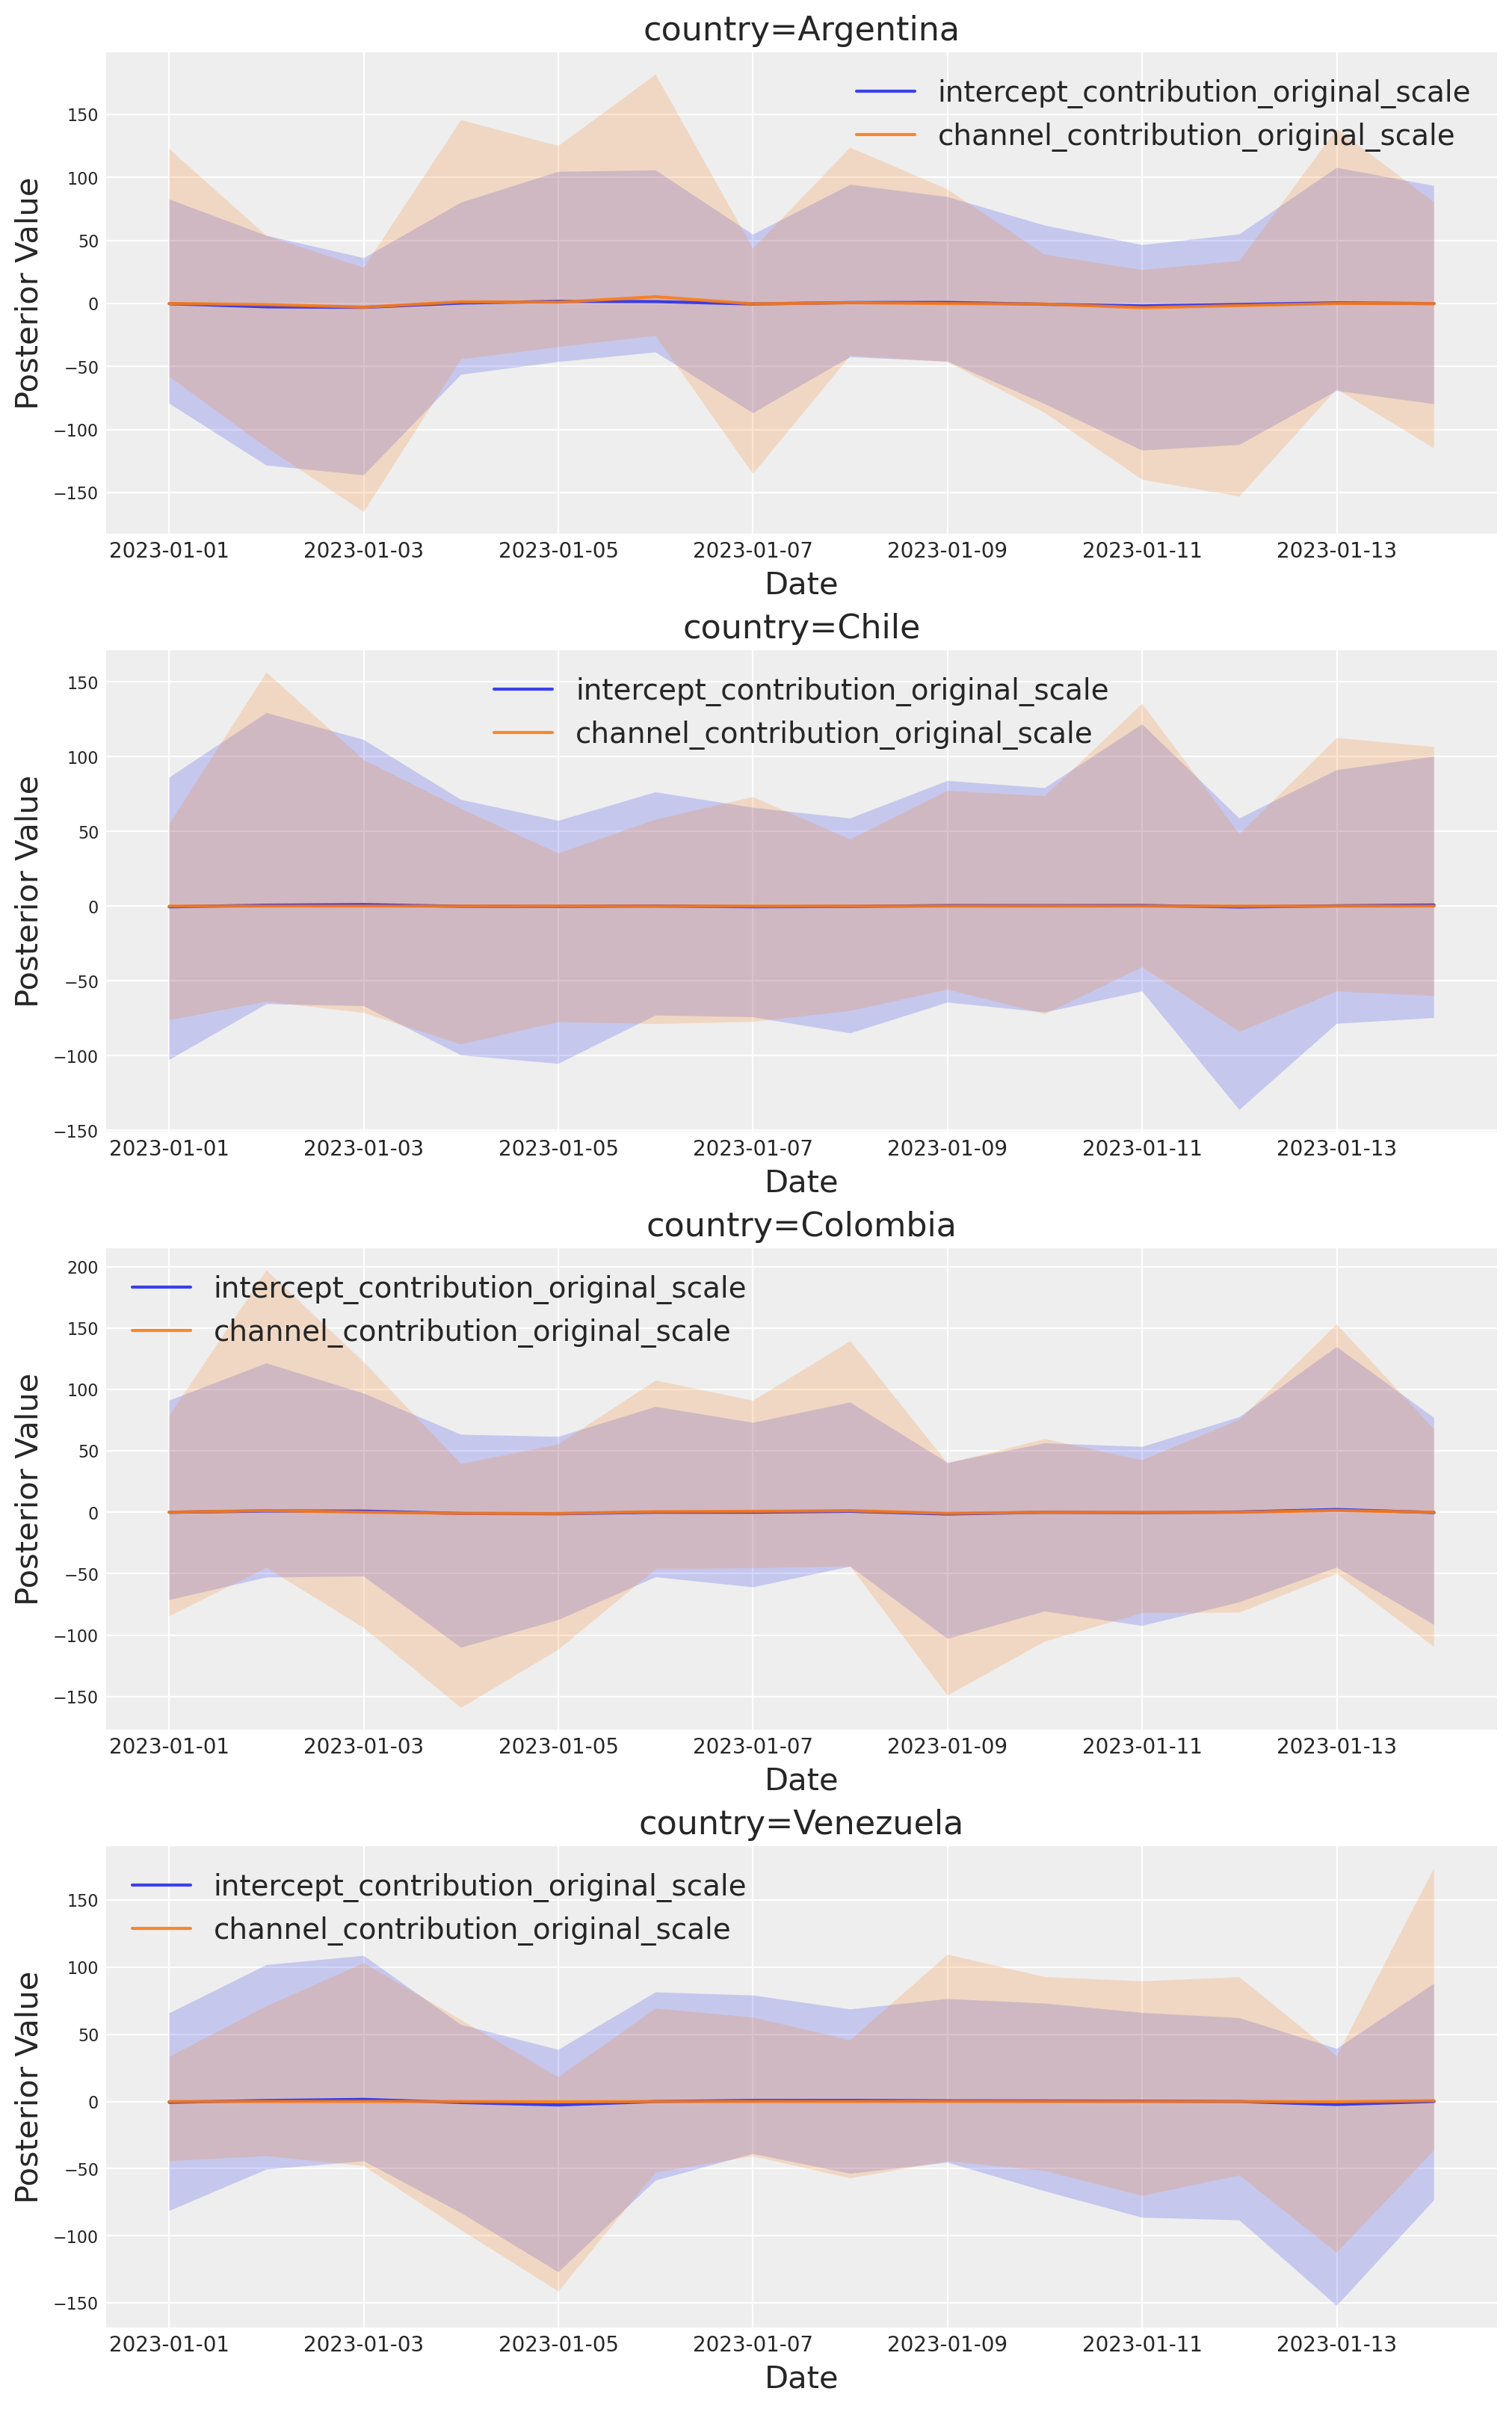

In [21]:
fig, ax = mmm.plot.contributions_over_time(
    var=[
        "intercept_contribution_original_scale",
        "channel_contribution_original_scale",
    ],
    ci=0.85,
)

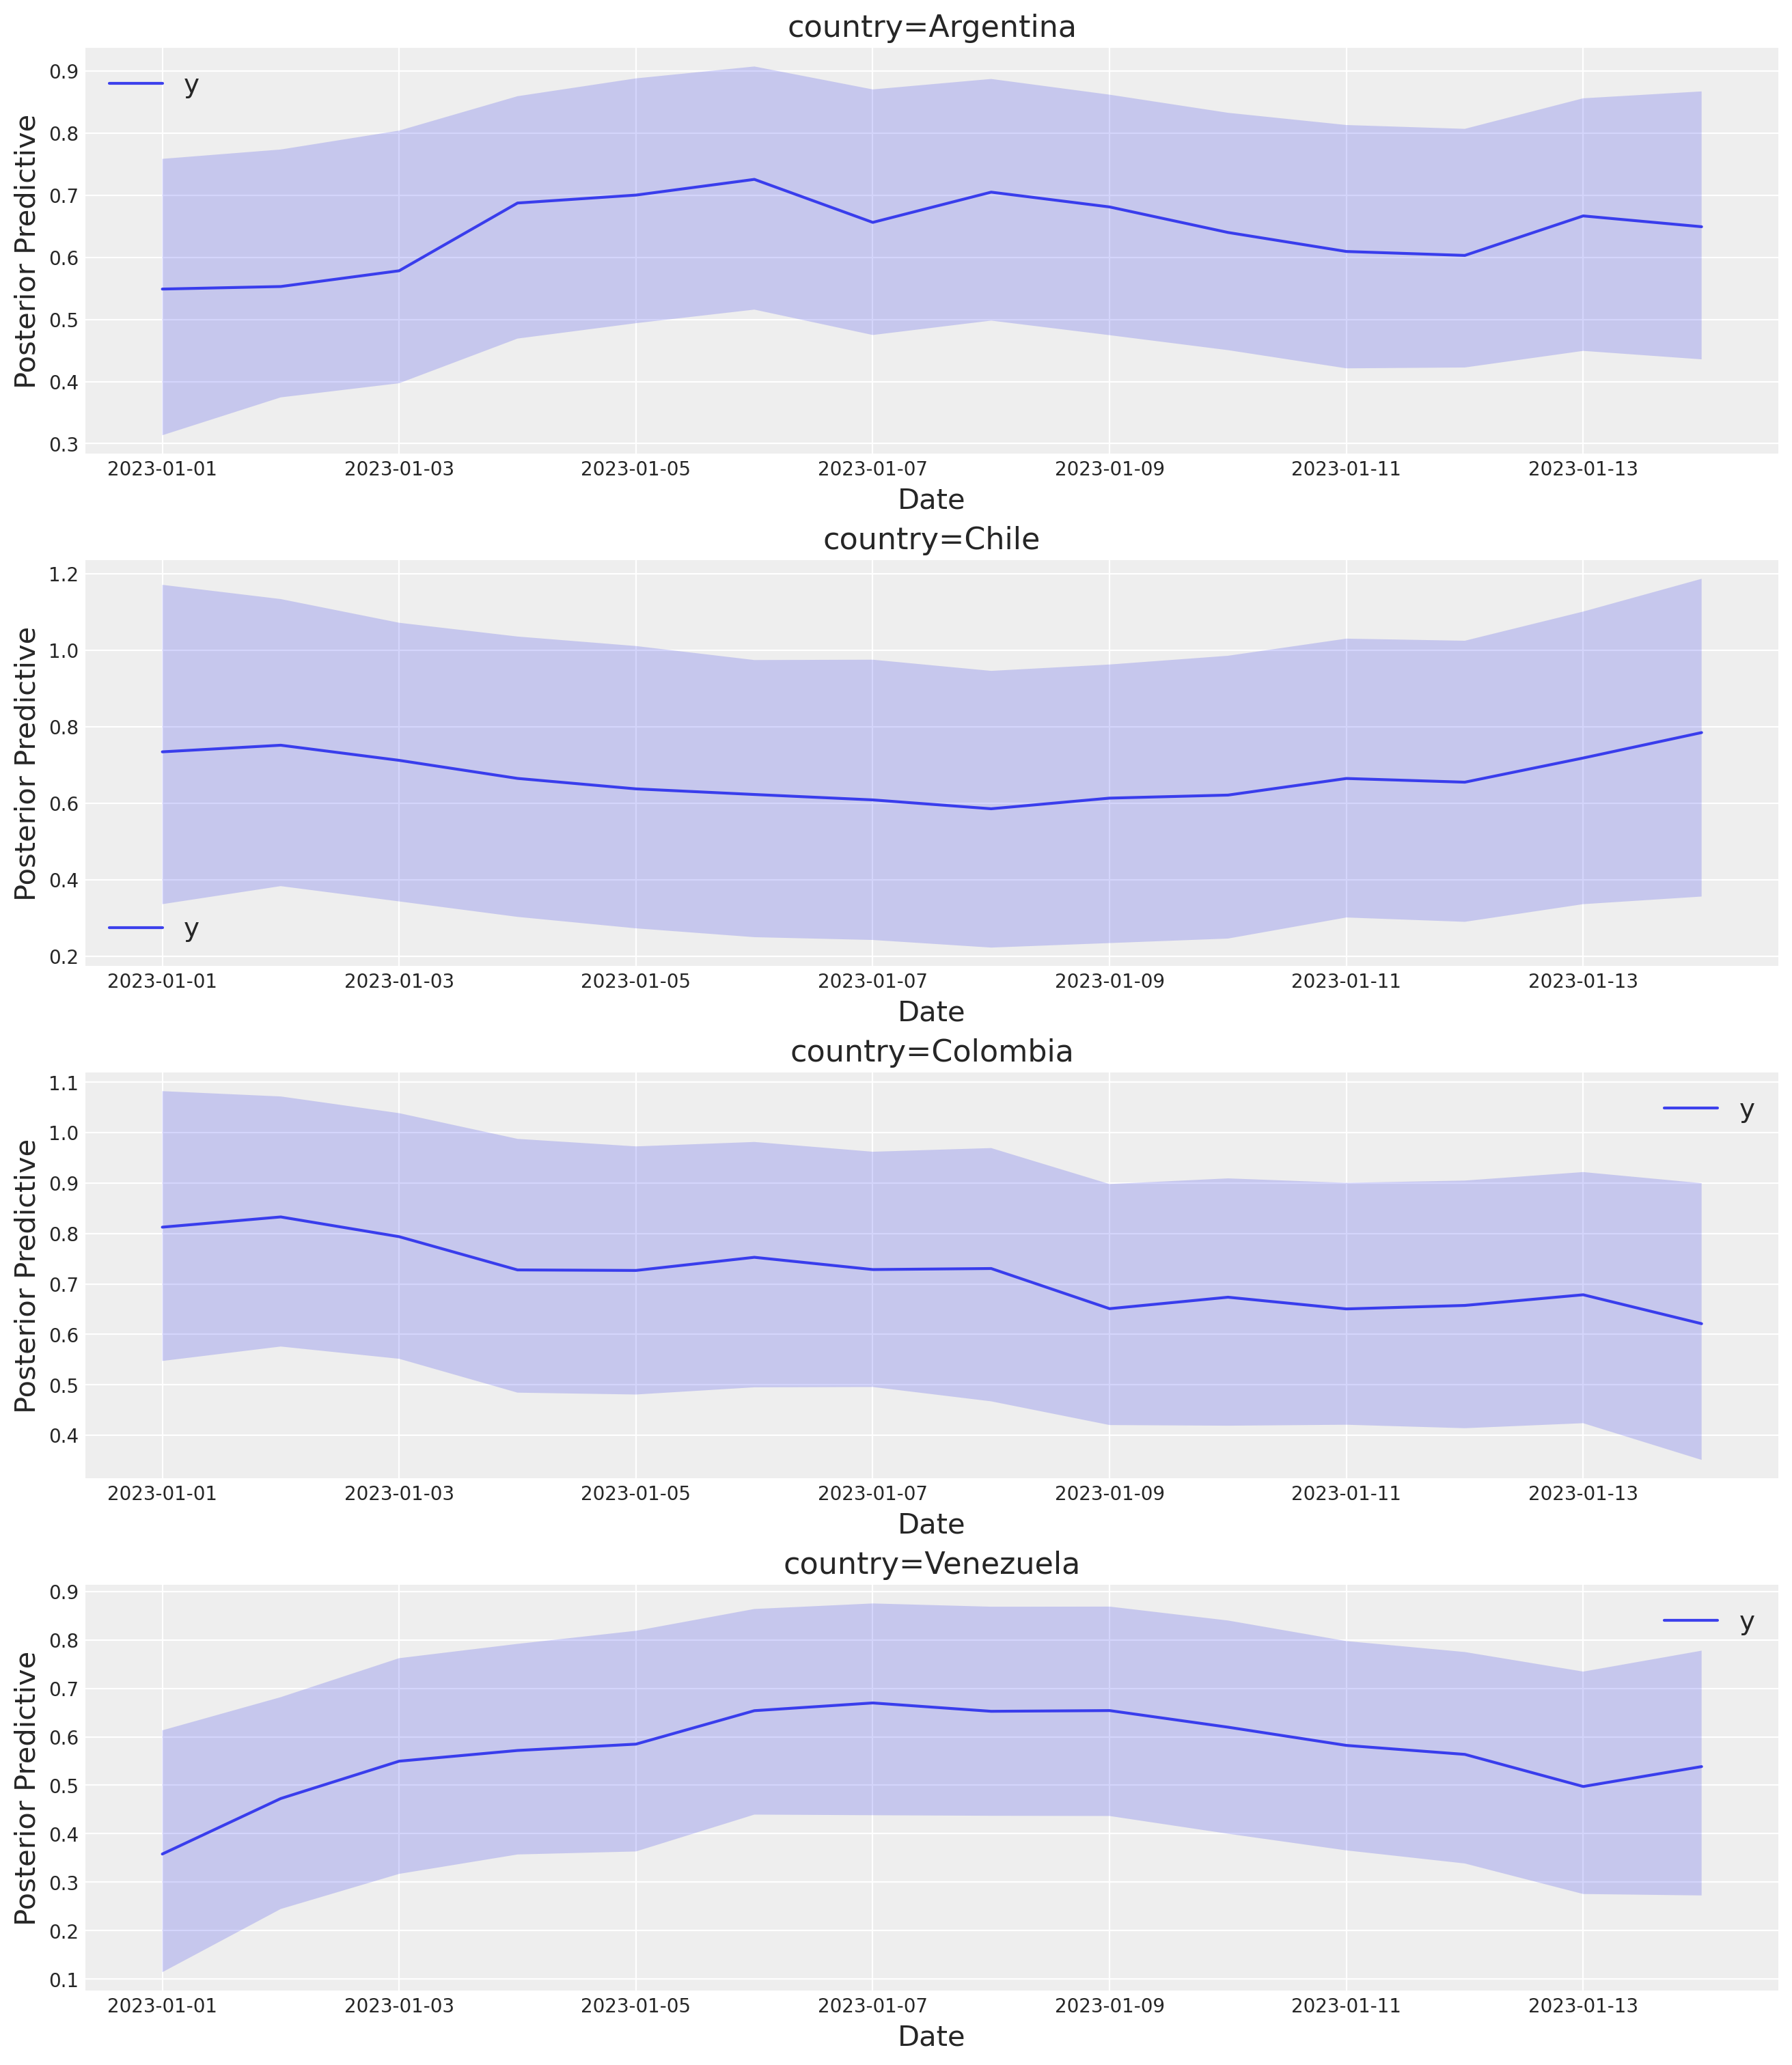

In [22]:
fig, ax = mmm.plot.posterior_predictive()
fig.set_size_inches(13, 15)

# Change the size of the axis letters to be smaller
for axis in ax.flatten():
    axis.tick_params(axis="both", which="major", labelsize=10)
    axis.tick_params(axis="both", which="minor", labelsize=8)

In [23]:
type(mmm.model["time_index"])

pytensor.tensor.sharedvar.TensorSharedVariable

In [24]:
_y_out_sample = mmm.sample_posterior_predictive(
    X=df_test.drop(columns="target"),
    extend_idata=False,
    include_last_observations=True,
    combined=True,
    random_seed=42,
    var_names=["channel_contribution", "intercept_contribution"],
    clone_model=True,
)
_y_out_sample

Sampling: []


Output()

<xarray.Dataset> Size: 6MB
Dimensions:                 (date: 16, country: 4, channel: 2, sample: 4000)
Coordinates:
  * date                    (date) datetime64[ns] 128B 2023-01-15 ... 2023-01-30
  * country                 (country) <U9 144B 'Argentina' ... 'Venezuela'
  * channel                 (channel) <U1 8B 'a' 'b'
  * sample                  (sample) object 32kB MultiIndex
  * chain                   (sample) int64 32kB 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3
  * draw                    (sample) int64 32kB 0 1 2 3 4 ... 996 997 998 999
Data variables:
    channel_contribution    (date, country, channel, sample) float64 4MB 0.00...
    intercept_contribution  (date, country, sample) float64 2MB -0.0003074 .....
Attributes:
    created_at:                 2025-02-02T11:35:58.323636+00:00
    arviz_version:              0.20.0
    inference_library:          pymc
    inference_library_version:  5.20.0

In [25]:
mmm = MMM(
    date_column="date",
    target_column="target",
    channel_columns=["a", "b"],
    # dims=("country",),
    adstock=GeometricAdstock(l_max=8),
    saturation=MichaelisMentenSaturation(),
)

# df.drop(columns="country", inplace=True)

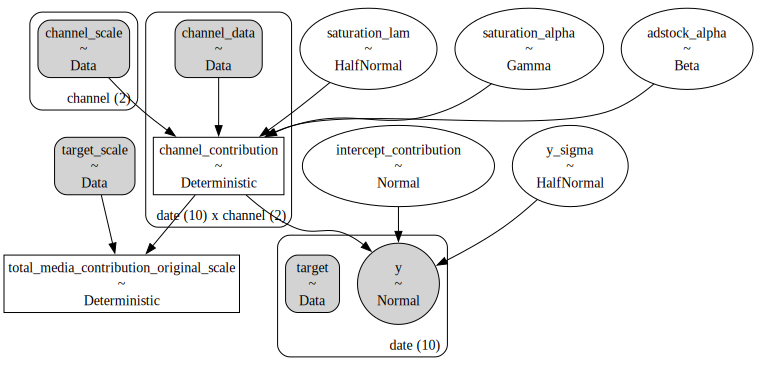

In [26]:
pm.model_to_graphviz(mmm.model)